In [148]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import numpy as np
from dotenv import load_dotenv
import os

## Adatok lematizálása és adatbázisba mentése

In [65]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

df = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)


In [66]:
from bs4 import BeautifulSoup

df['summary'] = df['summary'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())

In [67]:
df['text'] = df['title'] + ' ' + df['summary']

In [68]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text
0,29476,Első pillanattól kamu volt a forrongó régió le...,A Fülöp-szigetek védelmi minisztere megkérdője...,None,https://www.portfolio.hu/global/20250603/elso-...,Globál,None,2025-06-03 13:06:00,Első pillanattól kamu volt a forrongó régió le...
1,29477,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,None,https://www.portfolio.hu/global/20250603/vissz...,Globál,None,2025-06-03 13:04:00,Visszadobta Zelenszkij az orosz békefeltételek...
2,29478,"Ha az igaz, nagy a baj a fronton: 250 ezres uk...","Az orosz védelmi minisztérium ma bejelentette,...",None,https://www.portfolio.hu/global/20250603/ha-az...,Globál,None,2025-06-03 13:04:00,"Ha az igaz, nagy a baj a fronton: 250 ezres uk..."
3,29479,Példátlan beruházási hullám indul Németországb...,Németország idén alkotmányba foglalta egy 500 ...,None,https://www.portfolio.hu/befektetes/20250603/p...,Portfolio signature,None,2025-06-03 13:00:00,Példátlan beruházási hullám indul Németországb...
4,29480,Fordulat Lengyelországban - Mit gondolnak most...,A hétvégi lengyelországi elnökválasztás nem ho...,None,https://www.portfolio.hu/uzlet/20250603/fordul...,Portfolio signature,None,2025-06-03 13:00:00,Fordulat Lengyelországban - Mit gondolnak most...
5,29481,Az ellenzéki jelölt nyerhette a dél-koreai eln...,A mérések alapján magabiztos győzelmet aratott...,None,https://index.hu/kulfold/2025/06/03/del-korea-...,Külföld,None,2025-06-03 13:02:00,Az ellenzéki jelölt nyerhette a dél-koreai eln...
6,29482,"Extrém szupercella tört be az országba, kiadtá...","A csapadékot viharos, akár óránkénti 70 kilomé...",None,https://index.hu/belfold/2025/06/03/idojaras-r...,Belföld,None,2025-06-03 12:56:00,"Extrém szupercella tört be az országba, kiadtá..."
7,29483,Mit lép most Donald Tusk és Jarosław Kaczyński?,A kormányfő állítólag hamarosan átszervezi a k...,None,https://mandiner.hu/kulfold/2025/06/mit-lep-mo...,kulfold,None,2025-06-03 13:06:59,Mit lép most Donald Tusk és Jarosław Kaczyński...
8,29484,Forrósodik a levegő Romániában: NATO-tagország...,Nem sok jóra számíthat Oroszország.,None,https://mandiner.hu/kulfold/2025/06/forrosodik...,kulfold,None,2025-06-03 13:05:16,Forrósodik a levegő Romániában: NATO-tagország...
9,29485,Breaking: Ukrajna víz alatti robbantással táma...,Ukrajna ismét csapást mért az oroszok által ép...,None,https://mandiner.hu/kulfold/2025/06/breaking-u...,kulfold,None,2025-06-03 12:57:40,Breaking: Ukrajna víz alatti robbantással táma...


In [69]:
import huspacy
import spacy

huspacy.download()
nlp = spacy.load("hu_core_news_lg")

['C:\\Users\\KomPhone\\projects\\ml\\cubix_ml_vizsga\\.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


In [70]:
def lemmatize(text):
    doc = nlp(text.lower())
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    )

df['lemmatized_text'] = df['text'].apply(lemmatize)


In [71]:
from sqlalchemy.orm import Session
from app.db.database import SessionLocal
import app.models as models

db: Session = SessionLocal()

articles_to_update = (
    db.query(models.Articles)
    .filter(models.Articles.lemmatized_text.is_(None))
    .all()
)

lemmatized_map = dict(zip(df['link'], df['lemmatized_text']))

for article in articles_to_update:
    if article.link in lemmatized_map:
        article.lemmatized_text = lemmatized_map[article.link]

db.commit()
db.close()

## Kategoriák előkészítése

In [72]:
df = pd.read_sql("SELECT * FROM articles", con=engine)

In [73]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published
0,1,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,https://www.portfolio.hu/deviza/20250603/satub...,Deviza,None,2025-06-03 08:30:00
1,2,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,https://www.portfolio.hu/global/20250603/vissz...,Globál,None,2025-06-03 08:25:00
2,3,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,https://www.portfolio.hu/global/20250603/nyila...,Globál,None,2025-06-03 08:25:00
3,4,Sínre tették von der Leyen újabb százmilliárdo...,"Jó úton haladnak afelé, hogy még az év vége el...",sín tesz von der ley százmilliárdos keleti ügy...,https://www.portfolio.hu/unios-forrasok/202506...,Uniós források,None,2025-06-03 08:22:00
4,5,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,https://www.portfolio.hu/gazdasag/20250603/itt...,Gazdaság,None,2025-06-03 08:09:00
...,...,...,...,...,...,...,...,...
29496,29497,A lángok közt született hivatás - A tűzoltóság...,A tűz és az emberiség bonyolult kapcsolata hos...,láng közt született hivatás tűzoltóság rövid t...,https://magyarnemzet.hu/tudomany/2025/06/a-tuz...,alapértelmezett,None,2025-06-03 13:04:29
29497,29498,Diákmunka szabályosan: milliókat kereshetnek a...,A diákok szabályos foglalkoztatásának több fel...,diákmunka szabályos milliókat kereshet diák di...,https://magyarnemzet.hu/gazdasag/2025/06/diakm...,gazdaság,None,2025-06-03 12:58:50
29498,29499,Léteznek ekkora jégdarabok? Szupercella tarolj...,Egy veszteglő hidegfront hozza el az elmúlt he...,létezik ekkora jégdarab szupercella tarol orsz...,https://www.blikk.hu/aktualis/belfold/szuperce...,Aktuális,None,2025-06-03 13:02:45
29499,29500,Brutális családi balhé volt Szolnokon: ellepté...,Kedd délelőtt rendőri akció zavarta meg a szol...,brutális családi balhé szolnok ellep rendőr ut...,https://www.blikk.hu/aktualis/krimi/szolnok-re...,Aktuális,None,2025-06-03 12:56:18


In [74]:
df.drop([
    "id",
    "predicted_category",
    "published",
    "link"
], axis=1, inplace=True)

In [75]:
import unicodedata

def remove_accents(text):
    if isinstance(text, str):
        nfkd_form = unicodedata.normalize('NFKD', text)
        return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).lower()
    return text

df['category'] = df['category'].apply(remove_accents)

In [76]:
df.dropna(inplace=True)

### Kategoriák összevonása

In [77]:
df['category'] = df['category'].replace({
    'global': 'kulfold',
    'hirtvkulfold': 'kulfold',
    'kulpol': 'kulfold',
    'nagyvilag': 'kulfold',
    'vilag': 'kulfold',
    'celeb': 'bulvar',
    'sztarok': 'bulvar',
    'sztarvilag': 'bulvar',
    'kultur': 'kultura',
    'teve': 'bulvar',
    'techtud': 'tudomany',
    'techbazis': 'tudomany',
    'tech-tudomany': 'tudomany',
    'tech': 'tudomany',
    'itthon': 'belfold',
    'belpol': 'belfold',
    'politika': 'belfold',
    'nemzetkozi-gazdasag': 'gazdasag',
    'uzlet': 'gazdasag',
    'penz': 'gazdasag',
    'bank': 'gazdasag',
    'befektetes': 'gazdasag',
    'deviza': 'gazdasag',
    'vilaggazdasag-magyar-gazdasag': 'gazdasag',
    'elet-stilus': 'eletmod',
    'ferfiaknak': 'eletmod',
    'test-es-lelek': 'eletmod',
    'bunugyek': 'baleset-bunugy',
    'futball': 'sport',
    'foci': 'sport',
    'szorakozas': 'bulvar',
})

### Kategoriák eltávolítása
Értelmetlen valós információt nem tartalmazó kategoriák letávolítása

In [78]:
df = df[~df['category'].isin(['2023', 'hirek', 'hirado', 'aktualis', 'mindekozben'])]

Kategoriák szűrése

In [79]:
category_counts = df['category'].value_counts()

valid_categories = category_counts[category_counts >= 300].index

df = df[df['category'].isin(valid_categories)]


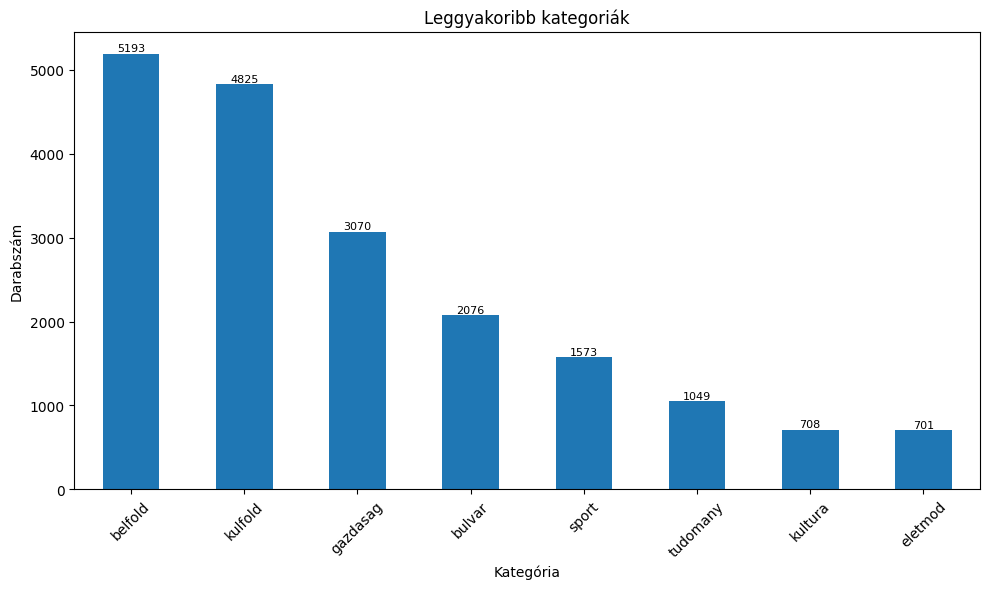

In [80]:
import matplotlib.pyplot as plt

top_categories = df['category'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
ax = top_categories.plot(kind='bar')

plt.title('Leggyakoribb kategoriák')
plt.xlabel('Kategória')
plt.ylabel('Darabszám')
plt.xticks(rotation=45)
plt.tight_layout()

for i, value in enumerate(top_categories.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.show()

In [81]:
df

,title,summary,lemmatized_text,category
0,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,gazdasag
1,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,kulfold
2,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,kulfold
4,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,gazdasag
5,Megnevezték az oroszok a bombázóflottát megbén...,Egy Artyom Timofejev nevű ukrán férfit gyanúsí...,megnevez orosz bombázóflotta megbénító támadás...,kulfold
...,...,...,...,...
29491,"Aki akar, talál munkát: ilyen kevés álláskeres...","A kormány célja, hogy mindenki, aki akar és tu...",akar talál munka kevés álláskereső kormány cél...,gazdasag
29492,Orbán Viktor: Magyarország továbbra is nemet m...,"Mára egyértelműen látszik, hogy a migráció oly...",orbán viktor magyarország továbbra nem mond il...,belfold
29494,"Jeszenszky Géza: Biztos, hogy célszemély voltam",A kalapáccsal megtámadott volt külügyminiszter...,jeszenszky géza biztos célszemély kalapács meg...,belfold
29495,Menekülne a Tisza Párt a politikai felelősségv...,"A Fidesz előre jelezte, hogy ebből baj lesz.",menekül tisza párt politikai felelősségvállalá...,belfold


## Kategoria predikció XGBoost-tel

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
df['combined'] = df['summary'] + ' ' + df['lemmatized_text']
X = vectorizer.fit_transform(df['combined'])

In [83]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])


In [84]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weight_dict = dict(zip(classes, class_weights))

# Minden sorhoz hozzárendeljük a megfelelő súlyt
sample_weights = np.array([weight_dict[label] for label in y])


In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)


In [86]:
import optuna
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


In [87]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)  # 10


[I 2025-06-03 15:09:33,883] A new study created in memory with name: no-name-6805cbee-8a1d-4e23-a0dc-4776fae3fbac
[I 2025-06-03 15:10:08,671] Trial 0 finished with value: 0.6449592668438862 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.08759149955432086, 'subsample': 0.9305440905868131, 'colsample_bytree': 0.9820044795953662, 'gamma': 9}. Best is trial 0 with value: 0.6449592668438862.
[I 2025-06-03 15:10:34,901] Trial 1 finished with value: 0.6624841993718251 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.27903932142820675, 'subsample': 0.9491527168962518, 'colsample_bytree': 0.7391737474539785, 'gamma': 8}. Best is trial 1 with value: 0.6624841993718251.


In [88]:
# study.stop()

In [89]:
print("Best trial:")
print("  Value (macro F1):", study.best_value)
print("  Params:", study.best_params)

Best trial:
  Value (macro F1): 0.6624841993718251
  Params: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.27903932142820675, 'subsample': 0.9491527168962518, 'colsample_bytree': 0.7391737474539785, 'gamma': 8}


In [90]:
best_model = XGBClassifier(
    **study.best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    n_jobs=-1
)

best_model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7391737474539785, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=8, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27903932142820675,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=287, n_jobs=-1, num_class=8, ...)

In [91]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     belfold       0.66      0.66      0.66      1039
      bulvar       0.72      0.73      0.72       415
     eletmod       0.48      0.59      0.53       140
    gazdasag       0.70      0.71      0.70       614
     kulfold       0.78      0.67      0.72       965
     kultura       0.53      0.59      0.56       142
       sport       0.90      0.82      0.86       314
    tudomany       0.45      0.70      0.55       210

    accuracy                           0.69      3839
   macro avg       0.65      0.68      0.66      3839
weighted avg       0.70      0.69      0.69      3839



In [92]:
import joblib
joblib.dump(best_model, "xgboost_best_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [93]:
def predict_category(text: str) -> str:
    text_clean = (lemmatize(text)).lower()
    X = vectorizer.transform([text_clean])
    pred = best_model.predict(X)
    return le.inverse_transform(pred)[0]


In [94]:
predict_category('A női energia aktiválása! 4 gyakorlat, hogy újra kapcsolódj a feminin énedhez')

'belfold'

## Kategória predikció Neurális hálóval-val

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['combined'])

le = LabelEncoder()
y = le.fit_transform(df['category'])
y_cat = to_categorical(y)

# 3. Tanító és teszt halmaz
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 4. Súlyozás a kiegyensúlyozatlan osztályokhoz
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = dict(enumerate(class_weights))

# 5. Neurális háló modell
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# 6. Tanítás
model.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=10,
    batch_size=64,
    class_weight=weight_dict,
    callbacks=[early_stop]
)

# 7. Értékelés
loss, acc = model.evaluate(X_test.toarray(), y_test)
print(f"Pontosság: {acc:.3f}")

Epoch 1/10
210/210 [==============================] - 2s 6ms/step - loss: 1.7698 - accuracy: 0.4553 - val_loss: 1.1184 - val_accuracy: 0.7079
Epoch 2/10
210/210 [==============================] - 1s 5ms/step - loss: 0.8912 - accuracy: 0.7429 - val_loss: 0.7881 - val_accuracy: 0.7451
Epoch 3/10
210/210 [==============================] - 1s 5ms/step - loss: 0.5398 - accuracy: 0.8199 - val_loss: 0.7588 - val_accuracy: 0.7405
Epoch 4/10
210/210 [==============================] - 1s 5ms/step - loss: 0.3555 - accuracy: 0.8670 - val_loss: 0.7632 - val_accuracy: 0.7475
Epoch 5/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2585 - accuracy: 0.8997 - val_loss: 0.8028 - val_accuracy: 0.7433
Epoch 6/10
210/210 [==============================] - 1s 5ms/step - loss: 0.1878 - accuracy: 0.9242 - val_loss: 0.8608 - val_accuracy: 0.7430
Epoch 7/10
90/90 [==============================] - 0s 1ms/step - loss: 0.7227 - accuracy: 0.7618
Pontosság: 0.762


In [120]:
model.save("category_predicter.keras")

## Tesztelés

In [125]:
from tensorflow.keras.models import load_model
import pickle

model = load_model("models/text_classifier.keras")

with open("models/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


1/1 [==============================] - 0s 26ms/step
Predikált osztály index: 4
Kategória: kulfold


In [135]:
tester = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)

In [142]:
tester["text"] = tester["title"].fillna("") + " " + tester["summary"].fillna("")
tester['lemmatized_text'] = tester['text'].apply(lemmatize)

tester["combined"] = tester["text"] + " " + tester['lemmatized_text']
X_new = vectorizer.transform(tester["combined"])

In [146]:
y_pred = model.predict(X_new.toarray())
y_labels = np.argmax(y_pred, axis=1)
tester["predicted_category"] = le.inverse_transform(y_labels)

2/2 [==============================] - 0s 2ms/step


In [147]:
tester

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text,combined
0,29502,"Hatalmas botrány tört ki Csehországban, a korm...","Az Andrej Babiš volt kormányfő vezette, jelenl...",hatalmas botrány tör csehország kormány sors t...,https://www.portfolio.hu/global/20250603/hatal...,Globál,kulfold,2025-06-03 13:24:00,"Hatalmas botrány tört ki Csehországban, a korm...","Hatalmas botrány tört ki Csehországban, a korm..."
1,29503,"Szupercella: felkészülhet a Balaton, baljós té...",Ausztria felől érkező szupercella érte el az M...,szupercella felkészülhet balat baljós térkép é...,https://www.portfolio.hu/gazdasag/20250603/szu...,Gazdaság,belfold,2025-06-03 13:12:00,"Szupercella: felkészülhet a Balaton, baljós té...","Szupercella: felkészülhet a Balaton, baljós té..."
2,29504,"Megtalálták a megoldást, így menekülhet meg a ...",A szakemberek folyamatosan figyelik a fejlemén...,megtalál megoldás menekülhet parajdi sóbánya s...,https://index.hu/kulfold/2025/06/03/parajd-sob...,Külföld,gazdasag,2025-06-03 13:44:00,"Megtalálták a megoldást, így menekülhet meg a ...","Megtalálták a megoldást, így menekülhet meg a ..."
3,29505,Azonnali egyeztetést követel a kormány és a fő...,"A Liga Szakszervezetek elárulták, mitől félnek...",azonnali egyeztetés követel kormány főváros sz...,https://index.hu/belfold/2025/06/03/budapest-i...,Belföld,belfold,2025-06-03 13:43:00,Azonnali egyeztetést követel a kormány és a fő...,Azonnali egyeztetést követel a kormány és a fő...
4,29506,"Szabalenka és Swiatek sem került bajba, összej...",A két klasszis különösebb probléma nélkül juto...,szabalenka swia kerül baj összejön várva várt ...,https://index.hu/sport/tenisz/2025/06/03/rolan...,Tenisz,sport,2025-06-03 13:40:00,"Szabalenka és Swiatek sem került bajba, összej...","Szabalenka és Swiatek sem került bajba, összej..."
...,...,...,...,...,...,...,...,...,...,...
59,29561,Angelina Jolie fia részegen tántorgott az utcán,Angelina Jolie és Brad Pitt fia alig állt a lá...,angelina jolie fia részeg tántorog utca angeli...,https://www.borsonline.hu/kulfoldi-sztarhirek/...,kulfoldi-sztarhirek,bulvar,2025-06-03 13:25:00,Angelina Jolie fia részegen tántorgott az utcá...,Angelina Jolie fia részegen tántorgott az utcá...
60,29562,"""Volt egy cisztám, ami rohamosan nőtt"" - azonn...",Aggasztó bejegyzésére sokan felkapták a fejüket.,cisztá rohamos nő azonnal műt házasság első lá...,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,bulvar,2025-06-03 13:20:00,"""Volt egy cisztám, ami rohamosan nőtt"" - azonn...","""Volt egy cisztám, ami rohamosan nőtt"" - azonn..."
61,29563,Nagy a baj: durva baleset történt a Győri úton,A műszaki mentést már megkezdték a tűzoltók.,baj durva baleset történik győri út műszaki me...,https://www.borsonline.hu/kek-hirek/2025/06/ba...,kek-hirek,belfold,2025-06-03 13:15:00,Nagy a baj: durva baleset történt a Győri úton...,Nagy a baj: durva baleset történt a Győri úton...
62,29564,„Így marad a halálában is halhatatlan a kisfia...,"Tizenhét évvel ezelőtt, mindössze 46 évesen hu...",marad halál halhatatlan kisfia flipper öcsi éd...,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,bulvar,2025-06-03 13:15:00,„Így marad a halálában is halhatatlan a kisfia...,„Így marad a halálában is halhatatlan a kisfia...
